In [1]:
import pandas as pd
import numpy as np
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_651a44c6256d4289950e25263ac926ad = 'https://s3.us.cloud-object-storage.appdomain.cloud'
else:
    endpoint_651a44c6256d4289950e25263ac926ad = 'https://s3.private.us.cloud-object-storage.appdomain.cloud'

client_651a44c6256d4289950e25263ac926ad = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='QaG9CCaAbuUWvmoq8UTBa8Oh9b4PM-yFULVsGptC0J94',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_651a44c6256d4289950e25263ac926ad)

body = client_651a44c6256d4289950e25263ac926ad.get_object(Bucket='waterqualitydrinkingwaterpotabili-donotdelete-pr-y19ucaazm8kmih',Key='water_potability.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [2]:
#shape of the data
df.shape

(3276, 10)

There are 3276 rows and 10 columns

In [3]:
#Check for missing values
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [4]:
#Dropping missing values
#because water quality is a sensitive data, we cannot tamper with the data by imputing mean, median, mode
df= df.dropna()


In [5]:
df.Potability.value_counts()

0    1200
1     811
Name: Potability, dtype: int64

Thus it is an imbalanced dataset, since 0 is much more 1 (1998>1278)
So we need to balance the data so that there is no biasedness.

In [6]:
zero  = df[df['Potability']==0]   #zero values in Potability column
one = df[df['Potability']==1]  # one values in Potability column
from sklearn.utils import resample
#minority class that  is 1, we need to upsample/increase that class so that there is no bias
#n_samples = 1998 means we want 1998 sample of class 1, since there are 1998 samples of class 0
df_minority_upsampled = resample(one, replace = True, n_samples = 1200) 
#concatenate
df = pd.concat([zero, df_minority_upsampled])

from sklearn.utils import shuffle
df = shuffle(df) # shuffling so that there is particular sequence

<AxesSubplot:ylabel='Potability'>

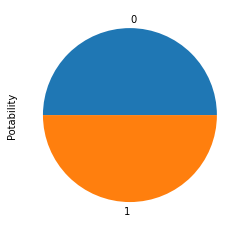

In [7]:
df.Potability.value_counts().plot(kind ='pie')

Now it's perfect!

There is no particular pattern!

In [8]:
df.corr().abs()['Potability'].sort_values(ascending = False)

Potability         1.000000
Trihalomethanes    0.033883
Turbidity          0.023435
Sulfate            0.017274
Chloramines        0.015443
Hardness           0.010373
ph                 0.003277
Solids             0.001718
Conductivity       0.000037
Organic_carbon     0.000035
Name: Potability, dtype: float64

highest correlation with Potability is solids with 5.24% only

In [9]:
X = df.drop(['Potability'], axis = 1)
y = df['Potability']

In [10]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
features= X.columns
X[features] = sc.fit_transform(X[features])

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier


from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1)

In [18]:
lr = LogisticRegression(random_state=42)
dt = DecisionTreeClassifier(criterion='entropy', max_depth=42, min_samples_leaf=1, random_state=42)
knn = KNeighborsClassifier(n_neighbors=1)
rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=2, random_state=42)
ada = AdaBoostClassifier(n_estimators= 600, learning_rate= 1 )
xgb = XGBClassifier()

#let's also apply bagging and boosting
bagging = BaggingClassifier(DecisionTreeClassifier(criterion='entropy', max_depth=46, min_samples_leaf=2, random_state=42),
                           n_estimators = 100, random_state = 42)
bagging.fit(X_train, y_train)


BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        max_depth=46,
                                                        min_samples_leaf=2,
                                                        random_state=42),
                  n_estimators=100, random_state=42)

In [20]:
classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn),
               ('Decision Tree', dt), ('Random Forest', rf), ('AdaBoost', ada),
              ('Bagging Classifier', bagging)]


In [21]:
from sklearn.metrics import accuracy_score

for classifier_name, classifier in classifiers:
 
    # Fit clf to the training set
    classifier.fit(X_train, y_train)    
   
    # Predict y_pred
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    

   
    # Evaluate clf's accuracy on the test set
    print('{:s} : {:.2f}'.format(classifier_name, accuracy))

Logistic Regression : 0.53
K Nearest Neighbours : 0.76
Decision Tree : 0.77
Random Forest : 0.88
AdaBoost : 0.65
Bagging Classifier : 0.85


Random Forest has performed better.

In [22]:
from sklearn.metrics import classification_report

y_pred_rf= rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.87      0.88      0.88       118
           1       0.88      0.88      0.88       122

    accuracy                           0.88       240
   macro avg       0.88      0.88      0.88       240
weighted avg       0.88      0.88      0.88       240



Accuracy is 88%